## Aplicações na area na financeira

In [163]:
import keras
import statsmodels.api as sm 

import yfinance
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

Obter dados financeiros pode ser bem dificil se estiver buscando um determinado produto ou resolução temporal.
> Alguns caso é necessario comprar

In [257]:
data = yfinance.download('^GSPC', start='1990-02-13', end='2020-08-10', auto_adjust=True)

[*********************100%***********************]  1 of 1 completed


In [258]:
data.columns = data.columns.droplevel(1)

In [259]:
data.head()

Price,Close,High,Low,Open,Volume
Date,,,,,
1990-02-13,331.019989,331.609985,327.920013,330.079987,144490000
1990-02-14,332.010010,333.200012,330.640015,331.019989,138530000
1990-02-15,334.890015,335.209991,331.609985,332.010010,174620000
1990-02-16,332.720001,335.640015,332.420013,334.890015,166840000
1990-02-20,327.989990,332.720001,326.260010,332.720001,147300000


In [260]:
data.index = pd.to_datetime(data.index, format='%Y-%m-%d')

<Axes: xlabel='Date'>

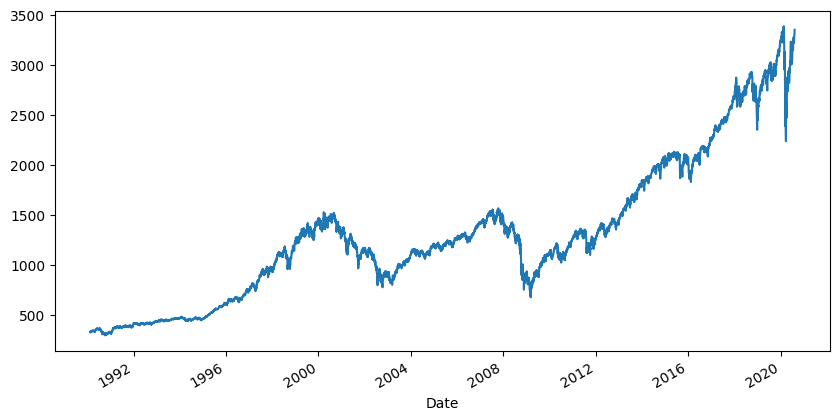

In [261]:
data['Close'].plot(figsize=(10, 5))

> Podemos ver que a série temporal não é estacionaria. Vemos também que pode ha ver diferentes regismes.

O potencial para pontos de mudança e diferentes regines indica que pode ser uma boa ideia dividir os dado em subconj. em diferentes subconj de dados para serem modelados de forma separada.

Vejamos se a normalização dos dados pode contribuir com a comparação dos dados de diferentes períods de tempo.

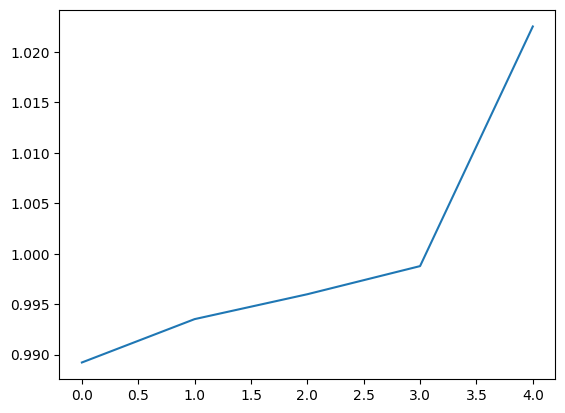

In [262]:
#1999
vals = data['1990-05-07':'1990-05-11']['Close'].values
plt.plot([i for i in range(len(vals))], np.array(vals)/np.mean(vals))

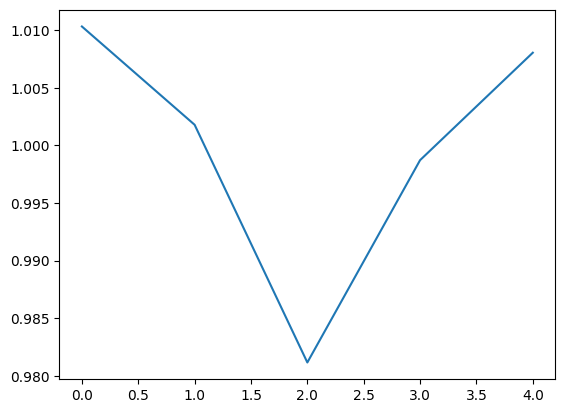

In [263]:
## 2000
vals = data['2000-05-08':'2000-05-12']['Close'].values
plt.plot([i for i in range(len(vals))], np.array(vals)/np.mean(vals))

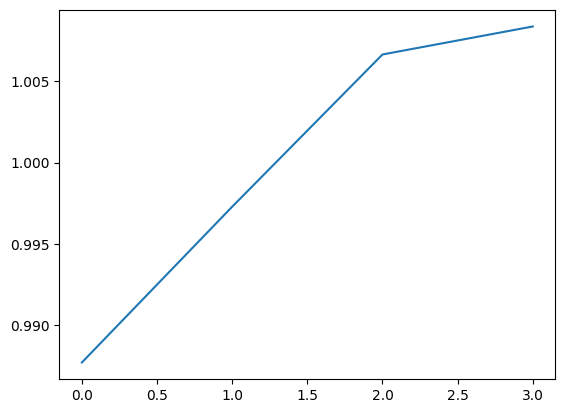

In [264]:
## 2018
vals = data['2018-05-08':'2018-05-12']['Close'].values
plt.plot([i for i in range(len(vals))], np.array(vals)/np.mean(vals))

Calculando o retorno diario, ou seja, **A mudannça do inicio ao final de cada trade day**

<Axes: xlabel='Date'>

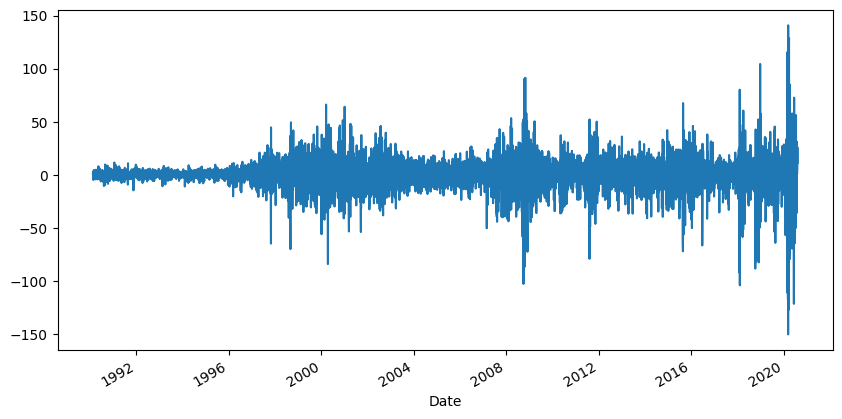

In [265]:
data['Retorno'] = data['Close'] - data['Open']
data['Retorno'].plot(figsize=(10, 5))

In [266]:
data['Retorno'].head()

Date
1990-02-13    0.940002
1990-02-14    0.990021
1990-02-15    2.880005
1990-02-16   -2.170013
1990-02-20   -4.730011
Name: Retorno, dtype: float64

In [267]:
data['Retorno'].apply(lambda x: 'Positivo' if x > 0 else 'Negativo').value_counts()

Retorno
Positivo    4108
Negativo    3573
Name: count, dtype: int64

Podemos ver que o grafico por si so não é o bastante para que os dados sejam comparaveis. Teremos tambem que encontrar uma forma de normalizar os dados sem um lookahead, **de modo que os valores que estamos usando para entradas e saídas em nosso modelos sejam mais uniformes ao longo do periodo do tempo de interesse**

## Pré-processamento de dados financeiros para Aprendizdo profundo

1. Criaremos novas quantidades de interesse economicamente significativas a partir das entrada brutas
2. Calcuremos uma média móvel exponencialmente podenrea e a variancia e quantidade de interesses para que possamos escalona-las sem uma lookahead
3. Empacoteremos nossos resultados para um formato adequado para o modelo de aprendizado profundo recorrente\

> **Financas quantitativas** aprender

Ja calculamos o retorno diario na seção anterior. Outra quantidade de interesse que podemos criar a partir das entradas brutas é a **volatilidade diaria** : Diferenca entre as cotações mais altas e mais baixas.

In [268]:
data['volatilidade'] = data['High'] - data['Low']

<Axes: xlabel='Date'>

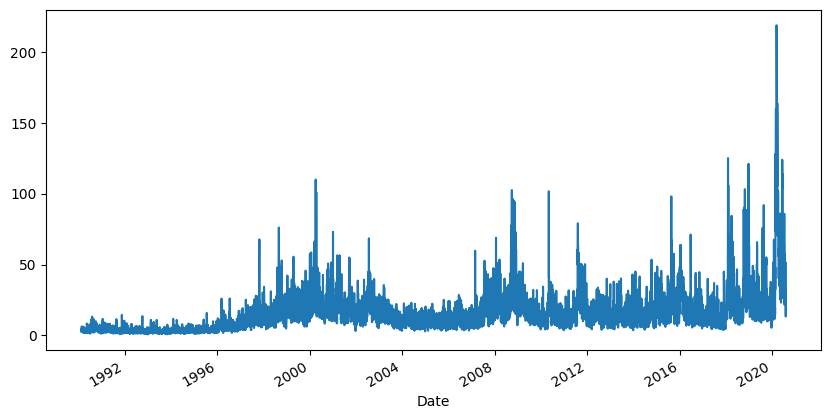

In [269]:
data['volatilidade'].plot(figsize=(10, 5))

## Escolonando quantidade de interesse **sem lookahead** 

```python
pd.Series.ewm()
```


* **com** (*center of mass*): controla a suavização via centro de massa.
* **span**: controla a suavização via um número de períodos equivalente.
* **halflife**: controla a suavização pelo tempo em que o peso cai pela metade.
    * halflife=10 → após 10 períodos, o peso é 0.5.
* **alpha**: define diretamente o fator de decaimento exponencial.
* **min\_periods**: número mínimo de observações necessárias para calcular um valor válido.
* **adjust**: se `True`, usa o cálculo ajustado (considera todo o histórico); se `False`, usa cálculo recursivo.
* **ignore\_na**: se `True`, ignora valores `NaN` nos cálculos.
* **axis**: indica o eixo em que aplicar (0 = linhas, 1 = colunas).



Para prever o retorno diário um dia a frente.
* Retorno diario anteriores
* Volatilidade diaria
* Volume diario anterior

Escalonaremos cada uma dessa quantidade, subtraindo a média movel exponencialmente ponderada e,em seguida, dividindo pelo desvio padrão exponencialmente ponderado

> Na exploração anterior demonstrou que, com o pré-processamento adequado, as várias quantidades de interesse podem ser transformadas em séries temporais estacionárias

In [270]:
# Suavização exponencial ponderad de cada coluna n
ewdf = data.ewm(halflife=10).mean()

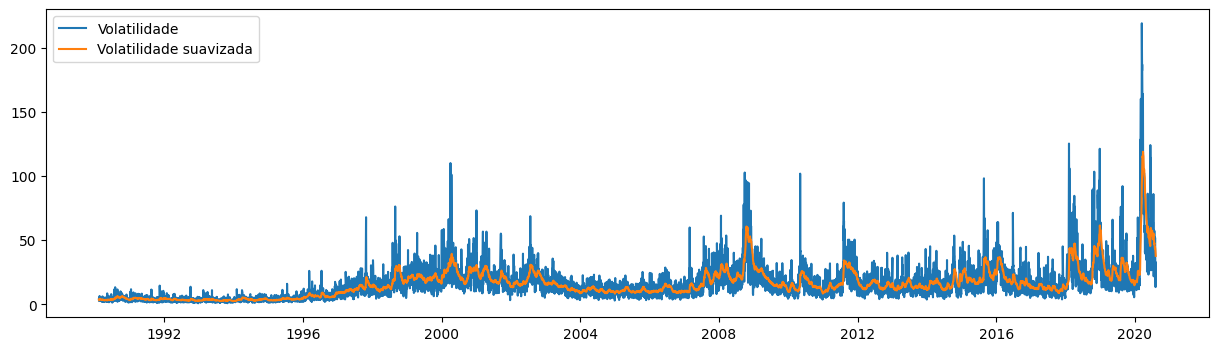

In [271]:
fig, ax = plt.subplots(figsize=(15, 4), ncols=1, nrows=1)

ax.plot(data['volatilidade'], label='Volatilidade')
ax.plot(ewdf['volatilidade'], label='Volatilidade suavizada')
ax.legend()

plt.show()

> Por mais que suavizado os valores brutos... ainda temos uma serie não estácionaria

<Axes: xlabel='Date'>

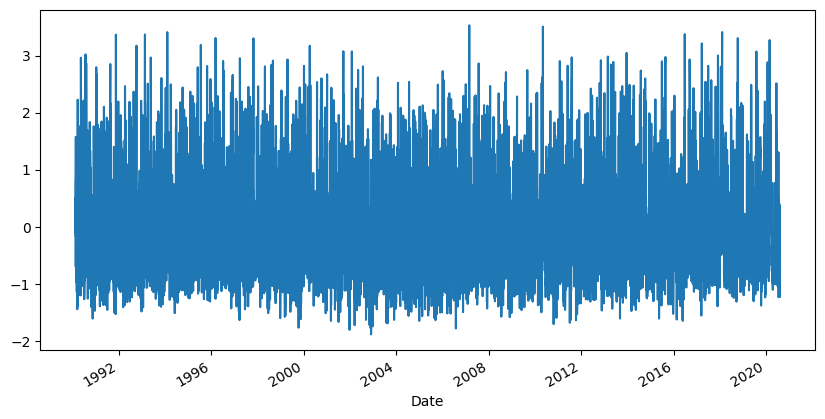

In [272]:
vewdf = data.ewm(halflife=10).var()

scaled = (data['volatilidade'] - ewdf['volatilidade'])/vewdf['volatilidade']**0.5
scaled.plot(figsize=(10, 5))

In [273]:
data['Vol_Escalonada'] = ((data['volatilidade'] - ewdf['volatilidade'])/vewdf['volatilidade']**0.5)
data['Retorno_Escalonado'] = ((data['Retorno'] - ewdf['Retorno'])/vewdf['Retorno']**0.5)
data['Voluma_Escalonado'] = ((data['Volume'] - ewdf['Volume'])/vewdf['Volume']**0.5)

In [274]:
data_train = data.dropna()

### Formatando nosso dados para uma rede neural

In [275]:
subset = data_train[['Vol_Escalonada', 'Retorno_Escalonado', 'Voluma_Escalonado']].copy(deep=True)
subset.head()

Price,Vol_Escalonada,Retorno_Escalonado,Voluma_Escalonado
Date,,,
1990-02-14,-0.682610,0.682610,-0.682610
1990-02-15,0.507880,1.095396,1.083513
1990-02-16,-0.088832,-1.272816,0.567948
1990-02-20,1.577997,-1.320389,-0.486045
1990-02-21,-0.172129,0.112849,0.261347


In [276]:
horizon = 10

In [277]:
X = data_train[['Vol_Escalonada', 'Retorno_Escalonado', 'Voluma_Escalonado']].values[:(7000-horizon)]

In [278]:
Y = data_train[['Retorno_Escalonado']].values[horizon:]

> y tem um problema : o problema com essa definição é que o valor de Y é o retorno em escala e não apenas o retorno. Apesar de isso ser o melhor para o treinamento, por que os valores estão dentro do intervalo apropriado, também significa que o Y que estamos predisento não é o real que nos interessa, e sim aquele retorno ajustado por uma media movel

In [279]:
X_ = np.expand_dims(X, axis=1)
X_.shape

(6990, 1, 3)

In [280]:
X_ = np.split(X_, X_.shape[0]/10, axis=0)
X_ = np.concatenate(X_, axis=1)
X_.shape

(10, 699, 3)

> Dado o formato TNC, temo series temporais de 10 de comprimento, com 3 entradas paralas. A partir delas temos 699 exemplo.

### Contruindo modelo e treinando

In [281]:
import tensorflow as tf

In [317]:
def gerador_dados(series, janela_tempo=5, horizon=1, is_tnc=False):
    
    X, y = [], []
    for i in range(len(series) - janela_tempo - horizon + 1):
        Xi = series[i:i + janela_tempo]



        yi = series[i + janela_tempo:i + janela_tempo + horizon]
        X.append(Xi)
        y.append(yi)
    if is_tnc:
        return None

    return np.array(X), y if type(y) is not list else np.array(y)

In [318]:
subset.shape

(7680, 3)

In [331]:
X, y = gerador_dados(subset.values, janela_tempo=10, horizon=1, is_tnc=False)

In [332]:
X.shape

(7670, 10, 3)

In [333]:
y = y[:, :, 1]
y.shape

(7670, 1)

In [ ]:
model = keras.Sequential([
    keras.layers.LSTM(10, input_shape=(X.shape[1], X.shape[2]), return_sequences=True),
    keras.layers.LSTM(10, return_sequences=False),
    keras.layers.Dense(1, kernel_regularizer=keras.regularizers.L1L2(l1=0.01, l2=0.01))
])

model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=80, verbose=0)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


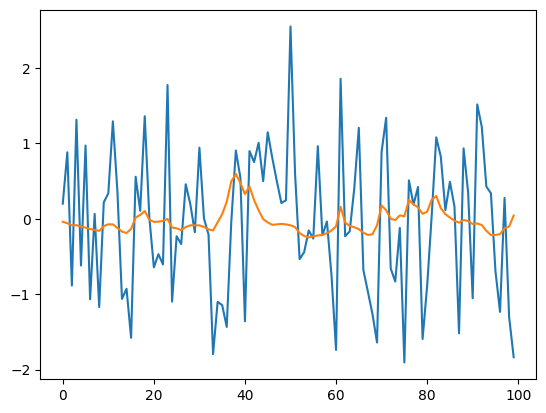

In [ ]:
plt.plot(y[:100])
plt.plot(model.predict(X[:100]))

In [ ]:
from scipy import stats

stats.pearsonr(y[:100], model.predict(X[:100]))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


PearsonRResult(statistic=array([0.2231297]), pvalue=array([0.0256509]))